### Введение

In [1]:
import pandas as  pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit

import shap
import ast  
import time
import random
import optuna


/Users/affiliation/Data_science/Validation/.project_venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_train = pd.read_json("../data/train.json")
df_test = pd.read_json("../data/test.json")

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49352 entries, 4 to 124009
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        49352 non-null  float64
 1   bedrooms         49352 non-null  int64  
 2   building_id      49352 non-null  object 
 3   created          49352 non-null  object 
 4   description      49352 non-null  object 
 5   display_address  49352 non-null  object 
 6   features         49352 non-null  object 
 7   latitude         49352 non-null  float64
 8   listing_id       49352 non-null  int64  
 9   longitude        49352 non-null  float64
 10  manager_id       49352 non-null  object 
 11  photos           49352 non-null  object 
 12  price            49352 non-null  int64  
 13  street_address   49352 non-null  object 
 14  interest_level   49352 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


In [4]:
df_train.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06


### Предварительная обработка

In [5]:
cols_to_keep_train = ['bathrooms', 'bedrooms', 'interest_level', 'created', 'price', 'features']
cols_to_keep_test  = ['bathrooms', 'bedrooms', 'features', 'created', 'price']

df_train = df_train[cols_to_keep_train].copy()
df_test  = df_test[cols_to_keep_test].copy()

df_train.head()

,bathrooms,bedrooms,interest_level,created,price,features
4,1.0,1,medium,2016-06-16 05:55:27,2400,"[Dining Room, Pre-War, Laundry in Building, Di..."
6,1.0,2,low,2016-06-01 05:44:33,3800,"[Doorman, Elevator, Laundry in Building, Dishw..."
9,1.0,2,medium,2016-06-14 15:19:59,3495,"[Doorman, Elevator, Laundry in Building, Laund..."
10,1.5,3,medium,2016-06-24 07:54:24,3000,[]
15,1.0,0,low,2016-06-28 03:50:23,2795,"[Doorman, Elevator, Fitness Center, Laundry in..."


In [6]:
q_low, q_high = df_train['price'].quantile([0.01, 0.99])

df_train = df_train[(df_train['price'] > q_low) & (df_train['price'] < q_high)]
df_test  = df_test[(df_test['price'] > q_low) & (df_test['price'] < q_high)]

In [7]:
empty_features_count = df_train['features'].apply(len).eq(0).sum()
print(f"Количество квартир с пустыми features: {empty_features_count}")

df_train = df_train[df_train['features'].apply(len) > 0].reset_index(drop=True)
df_train['features'] = df_train['features'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_test['features']  = df_test['features'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

Количество квартир с пустыми features: 3106


In [8]:
df_train.loc[df_train['bathrooms'] > 4.0, 'bathrooms'] = df_train['bathrooms'].mean()
df_test.loc[df_test['bathrooms'] > 4.0, 'bathrooms'] = df_test['bathrooms'].mean() 

In [9]:
le = LabelEncoder()
df_train['interest_level_encoded'] = le.fit_transform(df_train['interest_level'])

In [10]:
for index, flat_features in enumerate(df_train['features']):
    list_features = {'Elevator', 'Hardwood Floors', 'Cats Allowed', 'Dogs Allowed', 'Doorman', 'Dishwasher', 'No Fee', 'Laundry in Building', 'Fitness Center', 'Pre-War', 'Laundryin Unit', 'Roof Deck', 'Outdoor Space', 'Dining Room', 'High Speed Internet', 'Balcony', 'Swimming Pool', 'Laundry In Building', 'New Construction', 'Terrace'}
    for feature in flat_features:
        if feature in list_features:
            df_train.loc[index, feature] = 1
            list_features.remove(feature)
            
    for feature in list_features:
        df_train.loc[index, feature] = 0
            

In [11]:
df_train.columns

Index(['bathrooms', 'bedrooms', 'interest_level', 'created', 'price',
       'features', 'interest_level_encoded', 'Dining Room', 'Pre-War',
       'Laundry in Building', 'Dishwasher', 'Hardwood Floors', 'Dogs Allowed',
       'Cats Allowed', 'Elevator', 'Outdoor Space', 'New Construction',
       'No Fee', 'Swimming Pool', 'High Speed Internet', 'Laundry In Building',
       'Fitness Center', 'Laundryin Unit', 'Doorman', 'Terrace', 'Roof Deck',
       'Balcony'],
      dtype='object')

Text(0.5, 1.0, 'Гистограмма распределения цен на жильё')

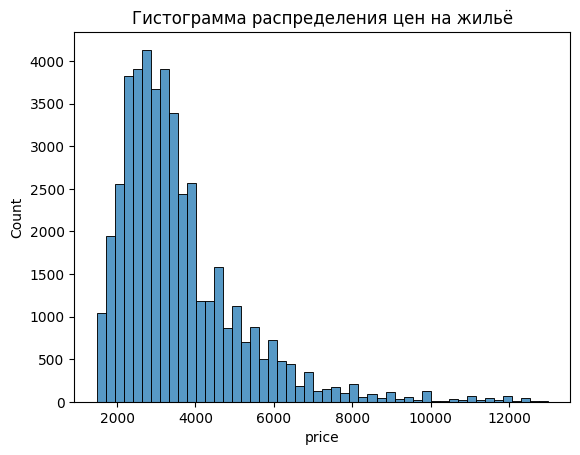

In [12]:
sns.histplot(data=df_train,
             x='price',
             bins=50)

plt.title('Гистограмма распределения цен на жильё')

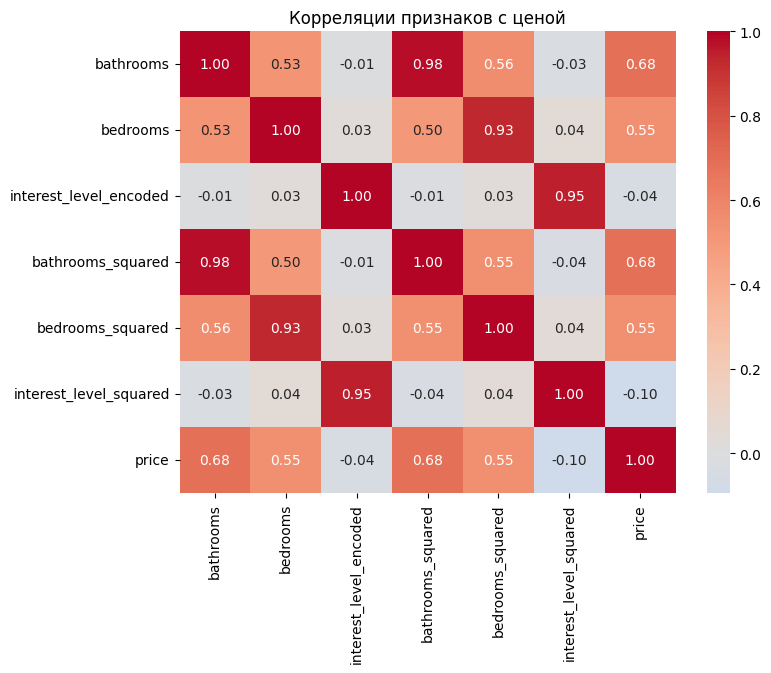

In [13]:
df_in_corr = df_train.copy()

df_in_corr['bathrooms_squared'] = df_in_corr['bathrooms'] ** 2
df_in_corr['bedrooms_squared'] = df_in_corr['bedrooms'] ** 2
df_in_corr['interest_level_squared'] = df_in_corr['interest_level_encoded'] ** 2

corr_matrix = df_in_corr[['bathrooms','bedrooms','interest_level_encoded',
                      'bathrooms_squared','bedrooms_squared','interest_level_squared',
                      'price']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Корреляции признаков с ценой")
plt.show()

In [14]:
df_train

,bathrooms,bedrooms,interest_level,created,price,features,interest_level_encoded,Dining Room,Pre-War,Laundry in Building,...,No Fee,Swimming Pool,High Speed Internet,Laundry In Building,Fitness Center,Laundryin Unit,Doorman,Terrace,Roof Deck,Balcony
0,1.0,1,medium,2016-06-16 05:55:27,2400,"[Dining Room, Pre-War, Laundry in Building, Di...",2,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,2,low,2016-06-01 05:44:33,3800,"[Doorman, Elevator, Laundry in Building, Dishw...",1,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,2,medium,2016-06-14 15:19:59,3495,"[Doorman, Elevator, Laundry in Building, Laund...",2,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0,low,2016-06-28 03:50:23,2795,"[Doorman, Elevator, Fitness Center, Laundry in...",1,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1.0,3,low,2016-06-28 05:59:06,7200,"[Doorman, Elevator, Loft, Dishwasher, Hardwood...",1,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45232,1.0,3,low,2016-04-05 03:58:33,2800,"[Elevator, Dishwasher, Hardwood Floors]",1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45233,1.0,2,medium,2016-04-02 02:25:31,2395,"[Common Outdoor Space, Cats Allowed, Dogs Allo...",2,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
45234,1.0,1,medium,2016-04-26 05:42:03,1850,"[Dining Room, Elevator, Pre-War, Laundry in Bu...",2,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45235,1.0,2,medium,2016-04-19 02:47:33,4195,"[Pre-War, Laundry in Unit, Dishwasher, No Fee,...",2,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


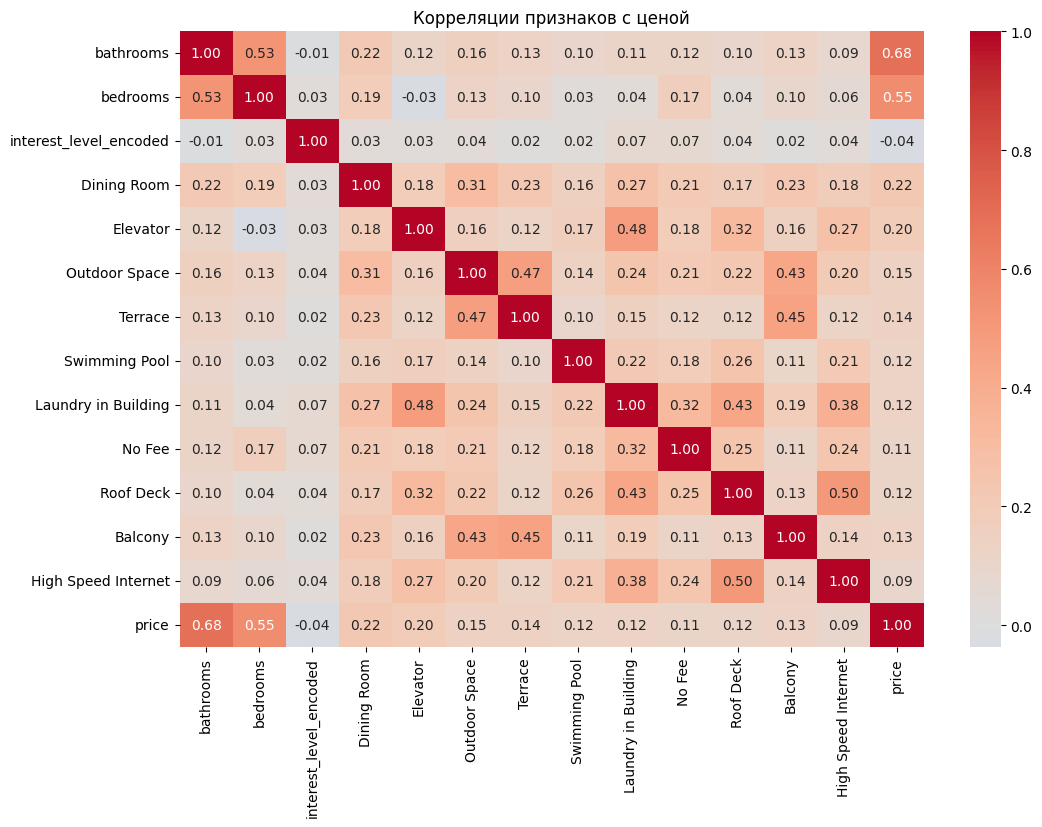

In [15]:
corr_matrix = df_in_corr[['bathrooms','bedrooms','interest_level_encoded', 'Dining Room', 'Elevator', 'Outdoor Space', 'Terrace', 'Swimming Pool', 'Laundry in Building', 'No Fee','Roof Deck','Balcony','High Speed Internet', 'price']].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Корреляции признаков с ценой")
plt.show()

In [16]:
X = df_train.drop(columns=["interest_level", "price", "features"])
y = df_train['price']

### Методы разбиения данных 

In [17]:
def random_split(X, y, test_size=0.2, random_state=None):
    n_samples = len(X)
    indices = np.arange(n_samples)
    # проверка на наличие random_state для воспроизводимости
    if random_state is not None:
        rng = np.random.default_rng(random_state)
        rng.shuffle(indices)
    else:
        np.random.shuffle(indices)
    # преобразование дробного размера тестовой выборки в абсолютное значение
    test_size_abs = int(n_samples * test_size)
    # распределение индексов для обучающей и тестовой выборок
    test_idx = indices[:test_size_abs]
    train_idx = indices[test_size_abs:]
    X_train = X.iloc[train_idx]
    X_test  = X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test  = y.iloc[test_idx]
    return X_train, X_test, y_train, y_test

In [18]:
def random_split_val(X, y, validation_size=0.2, test_size=0.2, random_state=None):
    n_samples = len(X)
    if validation_size + test_size >= 1:
        raise ValueError("validation_size + test_size должен быть < 1")
    indices = np.arange(n_samples)
    if random_state is not None:
        rng = np.random.default_rng(random_state)
        rng.shuffle(indices)
    else:
        np.random.shuffle(indices)
    test_end = int(n_samples * test_size)
    val_end  = test_end + int(n_samples * validation_size)

    test_idx = indices[:test_end]
    val_idx  = indices[test_end:val_end]
    train_idx = indices[val_end:]

    X_train = X.iloc[train_idx]
    X_val   = X.iloc[val_idx]
    X_test  = X.iloc[test_idx]

    y_train = y.iloc[train_idx]
    y_val   = y.iloc[val_idx]
    y_test  = y.iloc[test_idx]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [19]:
def date_split(X, y, date_column, date_split):
    X[date_column] = pd.to_datetime(X[date_column])
    train_mask = X[date_column] < date_split
    test_mask  = X[date_column] >= date_split
    X_train = X[train_mask]
    X_test  = X[test_mask]
    y_train = y[train_mask]
    y_test  = y[test_mask]
    return X_train, X_test, y_train, y_test

In [20]:
print(df_train['created'].min())
print(df_train['created'].max())

2016-04-01 22:12:41
2016-06-29 21:41:47


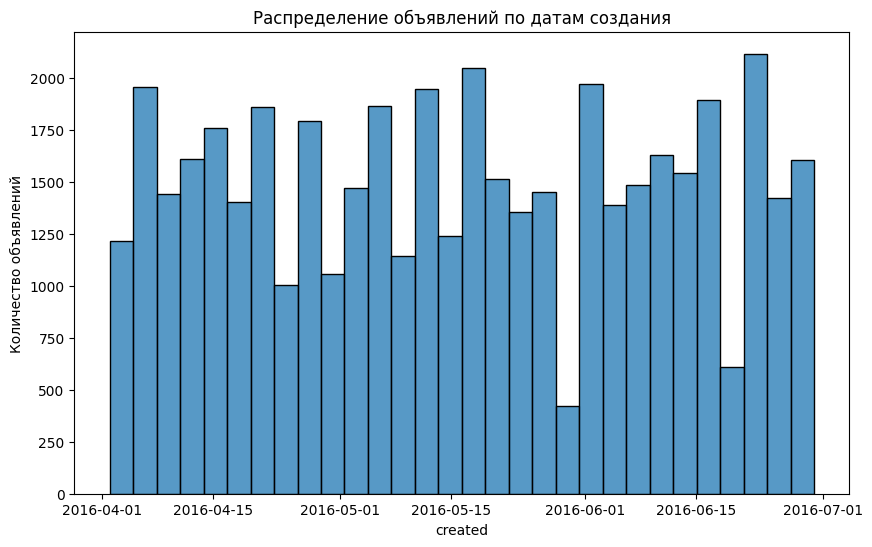

In [21]:
plt.figure(figsize=(10, 6))
df_train['created'] = pd.to_datetime(df_train['created'])
sns.histplot(data=df_train, x='created', bins=30, kde=False)
plt.ylabel('Количество объявлений')
plt.title('Распределение объявлений по датам создания') 
plt.show()

In [22]:
def date_split_val(X, y, date_column, validation_date, test_date):
    X[date_column] = pd.to_datetime(X[date_column])
    val_mask = (X[date_column] >= validation_date) & (X[date_column] < test_date)
    test_mask = X[date_column] >= test_date
    train_mask = ~val_mask & ~test_mask      # ~ и & - это операторы для массивов
    X_train = X[train_mask]
    X_val = X[val_mask]
    X_test = X[test_mask]
    y_train = y[train_mask]
    y_val = y[val_mask]
    y_test = y[test_mask]
    return X_train, X_val, X_test, y_train, y_val, y_test

### Методы перекрестной проверки:

In [23]:
def k_fold(n_samples, k, shuffle=False, random_state=None):
    indices = np.arange(n_samples)

    if shuffle:
        rng = np.random.default_rng(random_state)
        rng.shuffle(indices)

    fold_sizes = np.full(k, n_samples // k, dtype=int) # 
    fold_sizes[:n_samples % k] += 1

    current = 0
    folds = []
    for fold_size in fold_sizes:
        start = current
        stop = current + fold_size
        val_indices = indices[start:stop]
        train_indices = np.concatenate((indices[:start], indices[stop:])) 
        folds.append((train_indices, val_indices))
        current = stop
    return folds

Лучший фолд может отражать случайно благоприятное разбиение данных. Использование среднего значения метрики по всем фолдам позволяет получить более устойчивую и обобщающую оценку качества модели и снизить влияние случайности разбиения.Лучший фолд может отражать случайно благоприятное разбиение данных. Использование среднего значения метрики по всем фолдам позволяет получить более устойчивую и обобщающую оценку качества модели и снизить влияние случайности разбиения.

В K-Fold разбиение происходит по отдельным объектам, поэтому связанные объекты могут попасть одновременно в train и validation, что приводит к утечке информации.

В Group K-Fold разбиение происходит по группам, и все объекты одной группы целиком попадают либо в train, либо в validation, что предотвращает утечку информации между выборками.

In [24]:
def time_series(X, date_field, k):
    X_sorted = X.sort_values(by=date_field)
    indices = X_sorted.index.to_numpy()

    n_samples = len(indices)
    fold_size = n_samples // (k + 1)

    folds = []
    for i in range(k):
        train_end = fold_size * (i + 1)
        val_start = train_end
        val_end = val_start + fold_size

        train_idx = indices[:train_end]
        val_idx = indices[val_start:val_end]

        folds.append((train_idx, val_idx))

    return folds

### Сравнение всех методов проверки

In [25]:
results = []

TARGET = 'interest_level_encoded'
DATE_COL = 'created'

feature_columns = X.columns.drop(DATE_COL)

def build_model_data(X, feature_columns):
    return X[feature_columns].copy()

#### random_split

In [26]:
X_train, X_test, y_train, y_test = random_split(X, y, test_size=0.2, random_state=42)

X_train_model = build_model_data(X_train, feature_columns)
X_test_model  = build_model_data(X_test, feature_columns)

start = time.perf_counter()

model = LinearRegression()
model.fit(X_train_model, y_train)
test_mae = mean_absolute_error(y_test, model.predict(X_test_model))

elapsed = time.perf_counter() - start

results.append({
    'method': 'random_split',
    'val': np.nan,
    'test': test_mae,
    'time_sec': elapsed
})

#### random_split_val

In [27]:
X_train, X_val, X_test, y_train, y_val, y_test = random_split_val(X, y, validation_size=0.2, test_size=0.2, random_state=None)

X_train_model = build_model_data(X_train, feature_columns)
X_val_model   = build_model_data(X_val, feature_columns)
X_test_model  = build_model_data(X_test, feature_columns)

start = time.perf_counter()

model = LinearRegression()
model.fit(X_train_model, y_train)

val_mae = mean_absolute_error(y_val, model.predict(X_val_model))
test_mae = mean_absolute_error(y_test, model.predict(X_test_model))

elapsed = time.perf_counter() - start

results.append({
    'method': 'random_split_val',
    'val': val_mae,
    'test': test_mae,
    'time_sec': elapsed
})

#### date_split

In [28]:
X_train, X_test, y_train, y_test = date_split(X, y, date_column='created', date_split='2016-06-01')

X_train_model = build_model_data(X_train, feature_columns)
X_test_model  = build_model_data(X_test, feature_columns)

start = time.perf_counter()

model = LinearRegression()
model.fit(X_train_model, y_train)
test_mae = mean_absolute_error(y_test, model.predict(X_test_model))

elapsed = time.perf_counter() - start
    
results.append({
    'method': 'date_split',
    'val': np.nan,
    'test': test_mae
})

#### date_split_val

In [29]:
X_train, X_val, X_test, y_train, y_val, y_test = date_split_val(X, y, date_column='created', validation_date='2016-05-20', test_date='2016-06-11')

X_train_model = build_model_data(X_train, feature_columns)
X_val_model   = build_model_data(X_val, feature_columns)
X_test_model  = build_model_data(X_test, feature_columns)

start = time.perf_counter()

model = LinearRegression()
model.fit(X_train_model, y_train)

val_mae = mean_absolute_error(y_val, model.predict(X_val_model))
test_mae = mean_absolute_error(y_test, model.predict(X_test_model))

elapsed = time.perf_counter() - start

results.append({
    'method': 'date_split_val',
    'val': val_mae,
    'test': test_mae,
    'time_sec': elapsed
})

results_df = pd.DataFrame(results)
print(results_df)

             method         val        test  time_sec
0      random_split         NaN  720.246363  0.020184
1  random_split_val  708.144771  721.240190  0.012626
2        date_split         NaN  716.157710       NaN
3    date_split_val  720.377597  718.660968  0.008688


#### k_fold

In [30]:
splits = k_fold(n_samples=len(X), k=5, shuffle=False, random_state=None)

for train_idx, val_idx in splits:
    X_train_model = X.iloc[train_idx].drop(columns=['created'])
    X_val_model   = X.iloc[val_idx].drop(columns=['created'])

    y_train = y.iloc[train_idx]
    y_val   = y.iloc[val_idx]
    start = time.perf_counter()
    model = LinearRegression()
    model.fit(X_train_model, y_train)
    val_mae = mean_absolute_error(y_val,model.predict(X_val_model))
    
    elapsed = time.perf_counter() - start

results.append({
    'method': 'k_fold',
    'val': np.mean(val_mae),
    'test': np.nan,
    'time_sec': elapsed
})

In [31]:
splits

[(array([ 9048,  9049,  9050, ..., 45234, 45235, 45236], shape=(36189,)),
  array([   0,    1,    2, ..., 9045, 9046, 9047], shape=(9048,))),
 (array([    0,     1,     2, ..., 45234, 45235, 45236], shape=(36189,)),
  array([ 9048,  9049,  9050, ..., 18093, 18094, 18095], shape=(9048,))),
 (array([    0,     1,     2, ..., 45234, 45235, 45236], shape=(36190,)),
  array([18096, 18097, 18098, ..., 27140, 27141, 27142], shape=(9047,))),
 (array([    0,     1,     2, ..., 45234, 45235, 45236], shape=(36190,)),
  array([27143, 27144, 27145, ..., 36187, 36188, 36189], shape=(9047,))),
 (array([    0,     1,     2, ..., 36187, 36188, 36189], shape=(36190,)),
  array([36190, 36191, 36192, ..., 45234, 45235, 45236], shape=(9047,)))]

#### time_series

In [32]:
splits = time_series(X, date_field='created', k=5)
val_mae_scores = []
for train_idx, val_idx in splits:
    X_train_model = X.iloc[train_idx].drop(columns=['created'])
    X_val_model   = X.iloc[val_idx].drop(columns=['created'])

    y_train = y.iloc[train_idx]
    y_val   = y.iloc[val_idx]
    
    start = time.perf_counter()

    model = LinearRegression()
    model.fit(X_train_model, y_train)
    val_mae = mean_absolute_error(y_val, model.predict(X_val_model))
    val_mae_scores.append(val_mae)

    elapsed = time.perf_counter() - start

results.append({
    'method': 'time_series',
    'val': np.mean(val_mae_scores),
    'test': np.nan,
    'time_sec': elapsed
})

In [33]:
results_df = pd.DataFrame(results)
results_df

,method,val,test,time_sec
0,random_split,NaN,720.246363,0.020184
1,random_split_val,708.144771,721.240190,0.012626
2,date_split,NaN,716.157710,NaN
3,date_split_val,720.377597,718.660968,0.008688
4,k_fold,716.675675,NaN,0.010891
5,time_series,713.538933,NaN,0.010944


#### Применяю соответствующие методы из библиотеки sklearn.

#### train_test_split (sklearn)

In [34]:
X_model = X.drop(columns=['created'])
y_model = y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_model = build_model_data(X_train, feature_columns)
X_test_model  = build_model_data(X_test, feature_columns)

start = time.perf_counter()

model = LinearRegression()
model.fit(X_train_model, y_train)
test_mae = mean_absolute_error(y_test, model.predict(X_test_model))

elapsed = time.perf_counter() - start

results.append({
    'method': 'train_test_split (sklearn)',
    'val': np.nan,
    'test': test_mae,
    'time_sec': elapsed
})

#### train_test_split val (sklearn)

In [35]:
# 1) отделяем test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_model,
    y_model,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# 2) отделяем val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.25,  
    random_state=42,
    shuffle=True
)

X_train_model = build_model_data(X_train, feature_columns)
X_val_model   = build_model_data(X_val, feature_columns)
X_test_model  = build_model_data(X_test, feature_columns)

start = time.perf_counter()

model = LinearRegression()
model.fit(X_train_model, y_train)
val_mae = mean_absolute_error(y_val, model.predict(X_val_model))
test_mae = mean_absolute_error(y_test, model.predict(X_test_model))

elapsed = time.perf_counter() - start

results.append({
    'method': 'train_test_split val (sklearn)',
    'val': val_mae,
    'test': test_mae,
    'time_sec': elapsed
})

#### KFold (sklearn)

In [36]:
kf = KFold(n_splits=5, shuffle=False)

mae_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_model)):
    X_train = X_model.iloc[train_idx]
    X_val   = X_model.iloc[val_idx]

    y_train = y_model.iloc[train_idx]
    y_val   = y_model.iloc[val_idx]
    start = time.perf_counter()
    model = LinearRegression()
    model.fit(X_train, y_train)
    val_mae = mean_absolute_error(y_val, model.predict(X_val))

    elapsed = time.perf_counter() - start

    mae_scores.append(val_mae)

results.append({
    'method': 'KFold (sklearn)',
    'val': np.mean(mae_scores),
    'test': np.nan,
    'time_sec': elapsed
})

#### TimeSeriesSplit (sklearn)

In [37]:
X_sorted = X.sort_values('created')
y_sorted = y.loc[X_sorted.index]

X_model = X_sorted.drop(columns=['created'])

tscv = TimeSeriesSplit(n_splits=5)

mae_scores = []

for train_idx, val_idx in tscv.split(X_model):
    X_train = X_model.iloc[train_idx]
    X_val   = X_model.iloc[val_idx]

    y_train = y_sorted.iloc[train_idx]
    y_val   = y_sorted.iloc[val_idx]

    start = time.perf_counter()

    model = LinearRegression()
    model.fit(X_train, y_train)
    mae = mean_absolute_error(y_val, model.predict(X_val))
    mae_scores.append(mae)

    elapsed = time.perf_counter() - start

results.append({
    'method': 'TimeSeriesSplit (sklearn)',
    'val': np.mean(mae_scores),
    'test': np.nan,
    'time_sec': elapsed
})

In [38]:
results_df = pd.DataFrame(results)
results_df

,method,val,test,time_sec
0,random_split,NaN,720.246363,0.020184
1,random_split_val,708.144771,721.240190,0.012626
2,date_split,NaN,716.157710,NaN
3,date_split_val,720.377597,718.660968,0.008688
4,k_fold,716.675675,NaN,0.010891
5,time_series,713.538933,NaN,0.010944
6,train_test_split (sklearn),NaN,708.028171,0.011616
7,train_test_split val (sklearn),719.079888,707.431157,0.010804
8,KFold (sklearn),714.757212,NaN,0.010698
9,TimeSeriesSplit (sklearn),713.500549,NaN,0.011786


### Выбор функций

Построение модели регрессии Lasso с нормализованными признаками. Используйте мой метод разделения выборок на 3 части по полям, созданным в соотношении 60/20/20 — обучающая/валидационная/тестовая выборки.

In [39]:
X_train, X_val, X_test, y_train, y_val, y_test = date_split_val(
    X,
    y,
    date_column='created',
    validation_date='2016-05-20',
    test_date='2016-06-11'
)

X_train_model = build_model_data(X_train, feature_columns)
X_val_model   = build_model_data(X_val, feature_columns)
X_test_model  = build_model_data(X_test, feature_columns)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_model)
X_val_scaled   = scaler.transform(X_val_model)
X_test_scaled  = scaler.transform(X_test_model)

lasso = Lasso(alpha=0.1, random_state=42, max_iter=10_000)
lasso.fit(X_train_scaled, y_train)

y_val_pred = lasso.predict(X_val_scaled)
val_mae = mean_absolute_error(y_val, y_val_pred)
y_test_pred = lasso.predict(X_test_scaled)
test_mae = mean_absolute_error(y_test, y_test_pred)

results.append({
    'method': 'Lasso all features',
    'val': val_mae,
    'test': test_mae,
    'time_sec': np.nan
})

In [40]:
lasso_coefs = pd.Series(
    lasso.coef_,
    index=feature_columns
)

lasso_coefs_sorted = lasso_coefs.abs().sort_values(ascending=False)
lasso_coefs_sorted


bathrooms                 743.095401
bedrooms                  510.023605
Doorman                   290.712046
Dishwasher                118.770227
Laundry in Building       113.836683
Fitness Center            109.166998
Dogs Allowed              103.914212
Elevator                   99.749334
Laundry In Building        83.924544
Cats Allowed               72.162910
High Speed Internet        69.836403
No Fee                     65.249774
interest_level_encoded     62.649941
Hardwood Floors            51.688222
Terrace                    45.265756
Dining Room                33.084979
Roof Deck                  32.487207
Balcony                    21.289300
Outdoor Space              17.107560
Swimming Pool              10.365518
Pre-War                     8.663535
New Construction            0.339708
Laundryin Unit              0.000000
dtype: float64

In [41]:
top_10_features = lasso_coefs_sorted.head(10).index.tolist()

X_train_top10 = X_train[top_10_features]
X_val_top10   = X_val[top_10_features]
X_test_top10  = X_test[top_10_features]
scaler_tonp10 = StandardScaler()

X_train_top10_scaled = scaler_tonp10.fit_transform(X_train_top10)
X_val_top10_scaled   = scaler_tonp10.transform(X_val_top10)
X_test_top10_scaled  = scaler_tonp10.transform(X_test_top10)

In [42]:
lasso_top10 = Lasso(alpha=lasso.alpha, random_state=42, max_iter=10_000)

lasso_top10.fit(X_train_top10_scaled, y_train)

y_val_pred = lasso_top10.predict(X_val_top10_scaled)
val_mae = mean_absolute_error(y_val, y_val_pred)
y_test_pred = lasso_top10.predict(X_test_top10_scaled)
test_mae = mean_absolute_error(y_test, y_test_pred)

results.append({
    'method': 'Lasso / top 10 features',
    'val': val_mae,
    'test': test_mae,
    'time_sec': np.nan
})

In [43]:
results_df = pd.DataFrame(results)
print(results_df)

                            method         val        test  time_sec
0                     random_split         NaN  720.246363  0.020184
1                 random_split_val  708.144771  721.240190  0.012626
2                       date_split         NaN  716.157710       NaN
3                   date_split_val  720.377597  718.660968  0.008688
4                           k_fold  716.675675         NaN  0.010891
5                      time_series  713.538933         NaN  0.010944
6       train_test_split (sklearn)         NaN  708.028171  0.011616
7   train_test_split val (sklearn)  719.079888  707.431157  0.010804
8                  KFold (sklearn)  714.757212         NaN  0.010698
9        TimeSeriesSplit (sklearn)  713.500549         NaN  0.011786
10              Lasso all features  720.355395  718.648038       NaN
11         Lasso / top 10 features  729.938035  724.905720       NaN


Реализация метода для простого отбора признаков по соотношению NaN в признаках и корреляции.

In [44]:
def simple_feature_selection(
    X: pd.DataFrame,
    y: pd.Series,
    nan_threshold: float = 0.3,
    top_k: int = 10
):
    nan_ratio = X.isna().mean()
    good_nan_features = nan_ratio[nan_ratio <= nan_threshold].index

    X_clean = X[good_nan_features]

    corr = X_clean.apply(lambda col: col.corr(y)) # считаем корреляцию каждого столбца признака с y (целевой переменной)
    corr_abs = corr.abs().sort_values(ascending=False)

    selected_features = corr_abs.head(top_k).index.tolist()

    return selected_features, corr_abs

In [45]:
selected_features, corr_scores = simple_feature_selection(
    X_train,
    y_train,
    nan_threshold=0.3,
    top_k=10
)

/Users/affiliation/Data_science/Validation/.project_venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/affiliation/Data_science/Validation/.project_venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Признаки отбирались на основе доли пропусков и абсолютного значения корреляции с целевой переменной. Из рассмотрения исключались признаки с долей пропусков выше порога, после чего выбирались top-K признаков с наибольшей линейной связью с целевой переменной.

In [46]:
corr_scores

bathrooms                 0.680066
bedrooms                  0.557241
Doorman                   0.264122
Fitness Center            0.222480
Dishwasher                0.209954
Dining Room               0.206750
Elevator                  0.196069
Outdoor Space             0.142785
Terrace                   0.131005
Swimming Pool             0.118666
Laundry in Building       0.118370
No Fee                    0.117562
Roof Deck                 0.117526
Balcony                   0.114613
High Speed Internet       0.088165
Hardwood Floors           0.077970
New Construction          0.061921
Dogs Allowed              0.047714
Pre-War                   0.042875
Cats Allowed              0.035384
interest_level_encoded    0.033320
Laundry In Building       0.024532
created                   0.011137
Laundryin Unit                 NaN
dtype: float64

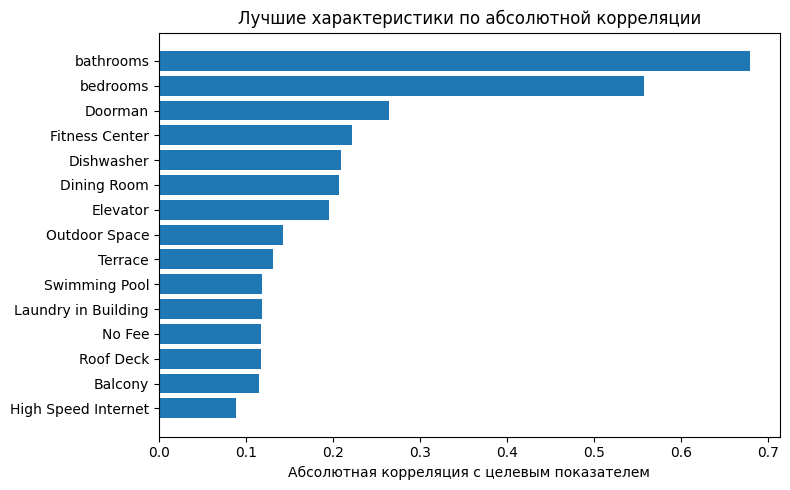

In [47]:

top_corr = corr_scores.head(15)

plt.figure(figsize=(8, 5))
plt.barh(top_corr.index[::-1], top_corr.values[::-1])
plt.xlabel("Абсолютная корреляция с целевым показателем")
plt.title("Лучшие характеристики по абсолютной корреляции")
plt.tight_layout()
plt.show()

In [48]:
top_corr

bathrooms              0.680066
bedrooms               0.557241
Doorman                0.264122
Fitness Center         0.222480
Dishwasher             0.209954
Dining Room            0.206750
Elevator               0.196069
Outdoor Space          0.142785
Terrace                0.131005
Swimming Pool          0.118666
Laundry in Building    0.118370
No Fee                 0.117562
Roof Deck              0.117526
Balcony                0.114613
High Speed Internet    0.088165
dtype: float64

In [49]:
X_train_sel = X_train[selected_features]
X_val_sel   = X_val[selected_features]
X_test_sel  = X_test[selected_features]

scaler_fs = StandardScaler()
X_train_sel_scaled = scaler_fs.fit_transform(X_train_sel)
X_val_sel_scaled   = scaler_fs.transform(X_val_sel)
X_test_sel_scaled  = scaler_fs.transform(X_test_sel)

model_fs = Lasso(alpha=0.01, max_iter=10_000, random_state=42)
model_fs.fit(X_train_sel_scaled, y_train)

val_mae_fs = mean_absolute_error(
    y_val,
    model_fs.predict(X_val_sel_scaled)
)

test_mae_fs = mean_absolute_error(
    y_test,
    model_fs.predict(X_test_sel_scaled)
)

results.append({
    'method': 'Feature selection',
    'val': val_mae_fs,
    'test': test_mae_fs,
    'time_sec': np.nan
})

Метод перестановочной важности

In [50]:
def permutation_importance(model, X_val, y_val, metric=mean_absolute_error):
    baseline = metric(y_val, model.predict(X_val))
    importances = {}

    for col in X_val.columns:
        X_permuted = X_val.copy()
        X_permuted[col] = np.random.permutation(X_permuted[col].values)

        permuted_score = metric(y_val, model.predict(X_permuted))
        importances[col] = permuted_score - baseline

    return importances

In [51]:
X_train_model = build_model_data(X_train, feature_columns)
X_val_model   = build_model_data(X_val, feature_columns)
X_test_model  = build_model_data(X_test, feature_columns)

model = LinearRegression()
model.fit(X_train_model, y_train)

perm_importance = permutation_importance(
    model,
    X_val_model,
    y_val
)

perm_df = (
    pd.Series(perm_importance)
      .sort_values(ascending=False)
)
feature_123 = perm_df.index.tolist()
top_10_features = perm_df.head(10).index.tolist()
print(top_10_features)

['bathrooms', 'bedrooms', 'Doorman', 'Laundry in Building', 'Dishwasher', 'Dogs Allowed', 'Fitness Center', 'Elevator', 'High Speed Internet', 'Cats Allowed']


In [52]:
feature_123

['bathrooms',
 'bedrooms',
 'Doorman',
 'Laundry in Building',
 'Dishwasher',
 'Dogs Allowed',
 'Fitness Center',
 'Elevator',
 'High Speed Internet',
 'Cats Allowed',
 'Hardwood Floors',
 'Laundry In Building',
 'No Fee',
 'interest_level_encoded',
 'Roof Deck',
 'Terrace',
 'Outdoor Space',
 'Balcony',
 'Dining Room',
 'Swimming Pool',
 'Pre-War',
 'Laundryin Unit',
 'New Construction']

In [53]:
X_train_top10 = X_train_model[top_10_features]
X_val_top10   = X_val_model[top_10_features]
X_test_top10  = X_test_model[top_10_features]

model_top10 = LinearRegression()
model_top10.fit(X_train_top10, y_train)

val_mae = mean_absolute_error(y_val, model_top10.predict(X_val_top10))
test_mae = mean_absolute_error(y_test, model_top10.predict(X_test_top10))

results.append({
    'method': 'Permutation importance (top 10)',
    'val': val_mae,
    'test': test_mae,
    'time_sec': np.nan
})

Применение модели Shape

In [54]:
X_train_model = build_model_data(X_train, feature_columns)
X_val_model   = build_model_data(X_val, feature_columns)
X_test_model  = build_model_data(X_test, feature_columns)

model = LinearRegression()
model.fit(X_train_model, y_train)

explainer = shap.LinearExplainer(model,X_train_model)
shap_values = explainer.shap_values(X_val_model) # получаем матрицу SHAP значений для валидационного набора

shap_importance = (
    pd.DataFrame({
        'feature': X_val_model.columns,
        'importance': np.abs(shap_values).mean(axis=0)  # получаем средний абсолютный вклад признака в предсказание модели
    })
    .sort_values(by='importance', ascending=False) # Сортировка по важности
)

In [55]:
print(shap_importance)

                   feature  importance
0                bathrooms  652.217786
1                 bedrooms  427.165948
19                 Doorman  287.132841
6               Dishwasher  119.931629
5      Laundry in Building  110.097343
8             Dogs Allowed  105.120190
10                Elevator  100.379834
17          Fitness Center  100.278017
9             Cats Allowed   73.690092
13                  No Fee   63.411237
7          Hardwood Floors   51.554605
2   interest_level_encoded   43.536199
15     High Speed Internet   41.761292
16     Laundry In Building   38.550046
3              Dining Room   23.572846
21               Roof Deck   23.307236
20                 Terrace   22.230387
11           Outdoor Space   13.827887
22                 Balcony   13.558736
4                  Pre-War    6.615719
14           Swimming Pool    6.005881
12        New Construction    0.222774
18          Laundryin Unit    0.000000


In [56]:
top_10_features = shap_importance.head(10)['feature'].tolist()

X_train_top10 = X_train_model[top_10_features]
X_val_top10   = X_val_model[top_10_features]
X_test_top10  = X_test_model[top_10_features]

model_top10 = LinearRegression()
model_top10.fit(X_train_top10, y_train)

val_mae = mean_absolute_error(y_val, model_top10.predict(X_val_top10))
test_mae = mean_absolute_error(y_test, model_top10.predict(X_test_top10))

results.append({
    'method': 'SHAP (top 10 features)',
    'val': val_mae,
    'test': test_mae,
    'time_sec': np.nan
})

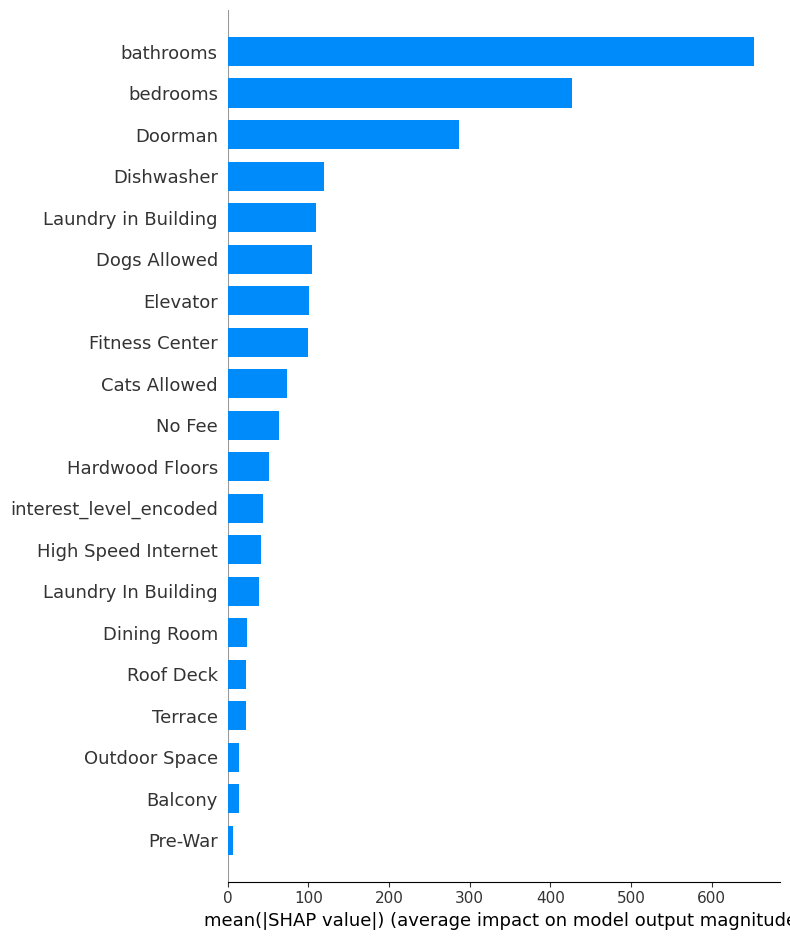

In [57]:
shap.summary_plot(
    shap_values,
    X_val_model,
    plot_type="bar"
)

SHAP-важность рассчитывается как средний абсолютный вклад признака в предсказание модели на валидационной выборке.

In [58]:
df_results = pd.DataFrame(results)
df_results 

,method,val,test,time_sec
0,random_split,NaN,720.246363,0.020184
1,random_split_val,708.144771,721.240190,0.012626
2,date_split,NaN,716.157710,NaN
3,date_split_val,720.377597,718.660968,0.008688
4,k_fold,716.675675,NaN,0.010891
5,time_series,713.538933,NaN,0.010944
6,train_test_split (sklearn),NaN,708.028171,0.011616
7,train_test_split val (sklearn),719.079888,707.431157,0.010804
8,KFold (sklearn),714.757212,NaN,0.010698
9,TimeSeriesSplit (sklearn),713.500549,NaN,0.011786


### Оптимизация гиперпараметров

#### Запуск optuna на схеме Grid Search

Методы перебора по сетке и случайного поиска для параметров alpha и l1_ratio в модели ElasticNet из библиотеки sklearn.

In [59]:
X_train_model = build_model_data(X_train, feature_columns)
X_val_model   = build_model_data(X_val, feature_columns)
X_test_model  = build_model_data(X_test, feature_columns)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_model)
X_val_scaled   = scaler.transform(X_val_model)
X_test_scaled  = scaler.transform(X_test_model)

In [60]:
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

best_mae = np.inf 
best_params = None

for alpha in param_grid['alpha']:
    for l1_ratio in param_grid['l1_ratio']:
        model = ElasticNet(
            alpha=alpha,
            l1_ratio=l1_ratio,
            random_state=42,
            max_iter=10_000
        )
        model.fit(X_train_scaled, y_train)

        val_pred = model.predict(X_val_scaled)
        val_mae = mean_absolute_error(y_val, val_pred)

        if val_mae < best_mae:
            best_mae = val_mae
            best_params = {'alpha': alpha, 'l1_ratio': l1_ratio}

best_model = ElasticNet(
    **best_params, 
    random_state=42,
    max_iter=10_000
)
start = time.perf_counter()

best_model.fit(X_train_scaled, y_train)
test_mae = mean_absolute_error(
    y_test,
    best_model.predict(X_test_scaled)
)
elapsed = time.perf_counter() - start
results.append({
    'method': 'ElasticNet Grid Search',
    'val': best_mae,
    'test': test_mae,
    'time_sec': np.nan
})

#### Реализовываю методы Random Search

In [61]:

alpha_range = np.logspace(-3, 1, 100)
l1_ratio_range = np.linspace(0.1, 0.9, 100)

n_iter = 30
best_mae = np.inf
best_params = None

for _ in range(n_iter):
    alpha = random.choice(alpha_range)
    l1_ratio = random.choice(l1_ratio_range)

    model = ElasticNet(
        alpha=alpha,
        l1_ratio=l1_ratio,
        random_state=42,
        max_iter=10_000
    )

    start = time.perf_counter()
    model.fit(X_train_scaled, y_train)

    val_pred = model.predict(X_val_scaled)
    val_mae = mean_absolute_error(y_val, val_pred)

    if val_mae < best_mae:
        best_mae = val_mae
        best_params = {'alpha': alpha, 'l1_ratio': l1_ratio}


In [62]:
best_model = ElasticNet(
    **best_params,
    random_state=42,
    max_iter=10_000
)
best_model.fit(X_train_scaled, y_train)
elapsed = time.perf_counter() - start
test_mae = mean_absolute_error(
    y_test,
    best_model.predict(X_test_scaled)
)

results.append({
    'method': 'ElasticNet Random Search',
    'val': best_mae,
    'test': test_mae,
    'time_sec': np.nan
})

In [63]:
df_results = pd.DataFrame(results)
print(df_results)

                             method         val        test  time_sec
0                      random_split         NaN  720.246363  0.020184
1                  random_split_val  708.144771  721.240190  0.012626
2                        date_split         NaN  716.157710       NaN
3                    date_split_val  720.377597  718.660968  0.008688
4                            k_fold  716.675675         NaN  0.010891
5                       time_series  713.538933         NaN  0.010944
6        train_test_split (sklearn)         NaN  708.028171  0.011616
7    train_test_split val (sklearn)  719.079888  707.431157  0.010804
8                   KFold (sklearn)  714.757212         NaN  0.010698
9         TimeSeriesSplit (sklearn)  713.500549         NaN  0.011786
10               Lasso all features  720.355395  718.648038       NaN
11          Lasso / top 10 features  729.938035  724.905720       NaN
12                Feature selection  738.841075  737.282510       NaN
13  Permutation impo

#### Наилучшее сочетание гиперпараметров модели

In [64]:
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

best_mae = np.inf
best_params = None

for alpha in param_grid['alpha']:
    for l1_ratio in param_grid['l1_ratio']:
        model = ElasticNet(
            alpha=alpha,
            l1_ratio=l1_ratio,
            random_state=42,
            max_iter=10_000
        )
        model.fit(X_train_scaled, y_train)

        val_pred = model.predict(X_val_scaled)
        val_mae = mean_absolute_error(y_val, val_pred)

        if val_mae < best_mae:
            best_mae = val_mae
            best_params = {
                'alpha': alpha,
                'l1_ratio': l1_ratio
            }

In [65]:
best_model = ElasticNet(
    **best_params,
    random_state=42,
    max_iter=10_000
)
best_model.fit(X_train_scaled, y_train)

test_mae = mean_absolute_error(
    y_test,
    best_model.predict(X_test_scaled)
)

In [66]:
print("Best params:", best_params)
print("Validation MAE:", best_mae)
print("Test MAE:", test_mae)

Best params: {'alpha': 0.1, 'l1_ratio': 0.7}
Validation MAE: 719.8884877297565
Test MAE: 718.7208049778084


In [67]:
X_train_final = pd.concat([X_train_model, X_val_model])
y_train_final = pd.concat([y_train, y_val])

scaler = StandardScaler()

X_train_final_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_model)

In [68]:
final_model = ElasticNet(
    alpha=0.1,
    l1_ratio=0.7,
    max_iter=10_000,
    random_state=42
)
final_model.fit(X_train_final_scaled, y_train_final)

y_test_pred = final_model.predict(X_test_scaled)
final_test_mae = mean_absolute_error(y_test, y_test_pred)

results.append({
    'method': 'ElasticNet Model with best params',
    'val': np.nan,
    'test': final_test_mae,
    'time_sec': np.nan
})

In [69]:
df_results = pd.DataFrame(results)
print(df_results)

                               method         val        test  time_sec
0                        random_split         NaN  720.246363  0.020184
1                    random_split_val  708.144771  721.240190  0.012626
2                          date_split         NaN  716.157710       NaN
3                      date_split_val  720.377597  718.660968  0.008688
4                              k_fold  716.675675         NaN  0.010891
5                         time_series  713.538933         NaN  0.010944
6          train_test_split (sklearn)         NaN  708.028171  0.011616
7      train_test_split val (sklearn)  719.079888  707.431157  0.010804
8                     KFold (sklearn)  714.757212         NaN  0.010698
9           TimeSeriesSplit (sklearn)  713.500549         NaN  0.011786
10                 Lasso all features  720.355395  718.648038       NaN
11            Lasso / top 10 features  729.938035  724.905720       NaN
12                  Feature selection  738.841075  737.282510   

In [70]:
X_train_model = build_model_data(X_train, feature_columns)
X_val_model   = build_model_data(X_val, feature_columns)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_model)
X_val_scaled   = scaler.transform(X_val_model)

#### Импорт Optuna и прровожу тот же эксперимент с ElasticNet

In [71]:
def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-3, 1.0, log=True)
    l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)

    model = ElasticNet(
        alpha=alpha,
        l1_ratio=l1_ratio,
        max_iter=10_000,
        random_state=42
    )

    model.fit(X_train_scaled, y_train)

    y_val_pred = model.predict(X_val_scaled)
    val_mae = mean_absolute_error(y_val, y_val_pred)

    return val_mae

In [72]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

[I 2026-02-03 17:07:58,352] A new study created in memory with name: no-name-3d037178-8d72-4451-9626-26eec886341b
[I 2026-02-03 17:07:58,386] Trial 0 finished with value: 720.3142288382843 and parameters: {'alpha': 0.002632567940904896, 'l1_ratio': 0.20698003987996005}. Best is trial 0 with value: 720.3142288382843.
[I 2026-02-03 17:07:58,394] Trial 1 finished with value: 726.0038892459579 and parameters: {'alpha': 0.3950697604653854, 'l1_ratio': 0.5280180957509244}. Best is trial 0 with value: 720.3142288382843.
[I 2026-02-03 17:07:58,403] Trial 2 finished with value: 751.2239921672336 and parameters: {'alpha': 0.49561835428692846, 'l1_ratio': 0.03262954567914056}. Best is trial 0 with value: 720.3142288382843.
[I 2026-02-03 17:07:58,432] Trial 3 finished with value: 720.2781076318226 and parameters: {'alpha': 0.005382367832946213, 'l1_ratio': 0.3825014466996727}. Best is trial 3 with value: 720.2781076318226.
[I 2026-02-03 17:07:58,446] Trial 4 finished with value: 719.8786674772099 

In [73]:
study.best_params

{'alpha': 0.9867114841695706, 'l1_ratio': 0.9662685826081645}

In [74]:
study.best_value

719.8334492306784

In [75]:
X_train_final = pd.concat([X_train_model, X_val_model])
y_train_final = pd.concat([y_train, y_val])

scaler = StandardScaler()
X_train_final_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_model)

final_model = ElasticNet(
    alpha=study.best_params['alpha'],
    l1_ratio=study.best_params['l1_ratio'],
    max_iter=10_000,
    random_state=42
)

final_model.fit(X_train_final_scaled, y_train_final)

y_test_pred = final_model.predict(X_test_scaled)
final_test_mae = mean_absolute_error(y_test, y_test_pred)

results.append({
    'method': 'ElasticNet Model (Optuna)',
    'val': np.nan,
    'test': final_test_mae,
    'time_sec': np.nan
})

In [76]:
df_results = pd.DataFrame(results)
df_results

,method,val,test,time_sec
0,random_split,NaN,720.246363,0.020184
1,random_split_val,708.144771,721.240190,0.012626
2,date_split,NaN,716.157710,NaN
3,date_split_val,720.377597,718.660968,0.008688
4,k_fold,716.675675,NaN,0.010891
5,time_series,713.538933,NaN,0.010944
6,train_test_split (sklearn),NaN,708.028171,0.011616
7,train_test_split val (sklearn),719.079888,707.431157,0.010804
8,KFold (sklearn),714.757212,NaN,0.010698
9,TimeSeriesSplit (sklearn),713.500549,NaN,0.011786


В рамках данного исследования были сравнены различные схемы валидации и подбора модели.
Несмотря на то, что случайные разбиения показали наилучшие значения MAE, они являются оптимистичными и потенциально нарушают временную структуру данных.
Наиболее корректным и устойчивым подходом оказался TimeSeriesSplit, как в реализации sklearn, так и в собственной реализации, демонстрируя сопоставимое качество при лучшей интерпретируемости и отсутствии утечек данных.
Методы отбора признаков и регуляризации (Lasso, ElasticNet, SHAP, permutation importance) не привели к улучшению качества, что указывает на распределённую информативность признаков.

#### Запуск optuna на одной из схем перекрестной проверки

In [77]:
X_model = X.drop(columns=['created'])
y_model = y

tscv = TimeSeriesSplit(n_splits=5)

In [78]:
def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-3, 1.0, log=True)
    l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)

    mae_scores = []

    for train_idx, val_idx in tscv.split(X_model):
        X_train = X_model.iloc[train_idx]
        X_val   = X_model.iloc[val_idx]

        y_train = y_model.iloc[train_idx]
        y_val   = y_model.iloc[val_idx]

        # масштабирование ТОЛЬКО на train
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled   = scaler.transform(X_val)

        model = ElasticNet(
            alpha=alpha,
            l1_ratio=l1_ratio,
            max_iter=10_000,
            random_state=42
        )

        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)

        mae = mean_absolute_error(y_val, y_pred)
        mae_scores.append(mae)

    return np.mean(mae_scores)

In [79]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

X_train, X_val, X_test, y_train, y_val, y_test = date_split_val(
    X,
    y,
    date_column='created',
    validation_date='2016-05-20',
    test_date='2016-06-11'
)

X_train_model = build_model_data(X_train, feature_columns)
X_test_model  = build_model_data(X_test, feature_columns)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_model)
X_test_scaled  = scaler.transform(X_test_model)

[I 2026-02-03 17:07:59,309] A new study created in memory with name: no-name-7eb34aea-7cde-4471-9a3b-81158eaa7ada
[I 2026-02-03 17:07:59,479] Trial 0 finished with value: 714.2432087291581 and parameters: {'alpha': 0.00488474481690531, 'l1_ratio': 0.14364399586260557}. Best is trial 0 with value: 714.2432087291581.
[I 2026-02-03 17:07:59,608] Trial 1 finished with value: 714.1240414924448 and parameters: {'alpha': 0.024115326266285386, 'l1_ratio': 0.6346788403020043}. Best is trial 1 with value: 714.1240414924448.
[I 2026-02-03 17:07:59,673] Trial 2 finished with value: 715.9698494143255 and parameters: {'alpha': 0.8433903390888228, 'l1_ratio': 0.8459365220641969}. Best is trial 1 with value: 714.1240414924448.
[I 2026-02-03 17:07:59,736] Trial 3 finished with value: 737.6987804172329 and parameters: {'alpha': 0.49465624179930895, 'l1_ratio': 0.15846515443544096}. Best is trial 1 with value: 714.1240414924448.
[I 2026-02-03 17:07:59,799] Trial 4 finished with value: 717.7557402856448 a

In [80]:
best_alpha = study.best_params['alpha']
best_l1_ratio = study.best_params['l1_ratio']

final_model = ElasticNet(
    alpha=best_alpha,
    l1_ratio=best_l1_ratio,
    max_iter=10_000,
    random_state=42
)

final_model.fit(X_train_scaled, y_train)

y_test_pred = final_model.predict(X_test_scaled)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = mean_squared_error(y_test, y_test_pred)

results.append({
    'method': 'ElasticNet (Optuna + TimeSeriesSplit)',
    'val': np.nan,
    'test': test_mae,
    'time_sec': np.nan

})

In [81]:
df_results = pd.DataFrame(results)
df_results

,method,val,test,time_sec
0,random_split,NaN,720.246363,0.020184
1,random_split_val,708.144771,721.240190,0.012626
2,date_split,NaN,716.157710,NaN
3,date_split_val,720.377597,718.660968,0.008688
4,k_fold,716.675675,NaN,0.010891
5,time_series,713.538933,NaN,0.010944
6,train_test_split (sklearn),NaN,708.028171,0.011616
7,train_test_split val (sklearn),719.079888,707.431157,0.010804
8,KFold (sklearn),714.757212,NaN,0.010698
9,TimeSeriesSplit (sklearn),713.500549,NaN,0.011786


Подбор гиперпараметров ElasticNet с использованием Optuna и временной перекрёстной проверки (TimeSeriesSplit) не привёл к значимому улучшению качества по сравнению с базовой линейной регрессией.
Это свидетельствует о том, что модель уже близка к оптимальной в рамках линейных зависимостей и текущего набора признаков.